In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n' \
          'You should consider updating to Python 3.4.0 or ' \
          'higher as the libraries built for this course ' \
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda '
          'and then restart `jupyter notebook`:\n' \
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    print('Done!')

# Import Tensorflow
try:
    import tensorflow as tf
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
try:
    from libs import utils
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Bit of formatting because inline code is not styled very good by default:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

# Download The Images

In [3]:
dirname = '/Users/vibertthio/Documents/Python/cadl/session-1/google_image_downloader/dataset/trump'

# Load every image file in the provided directory
filenames = [os.path.join(dirname, fname)
             for fname in os.listdir(dirname)]



In [4]:
filenames = [fn for fn in filenames if '.DS_Store' not in fn]

In [5]:
# Make sure we have exactly 100 image files!
filenames = filenames[:100]
assert(len(filenames) == 100)

In [6]:
imgs = [plt.imread(fname)[..., :3] for fname in filenames]
imgs = [utils.imcrop_tosquare(img_i) for img_i in imgs]
imgs = [resize(img_i, (100, 100, 3)) for img_i in imgs]
imgs = np.array(imgs).astype(np.float32)

/Users/vibertthio/.pyenv/versions/3.5.4/envs/cadl/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/vibertthio/.pyenv/versions/3.5.4/envs/cadl/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


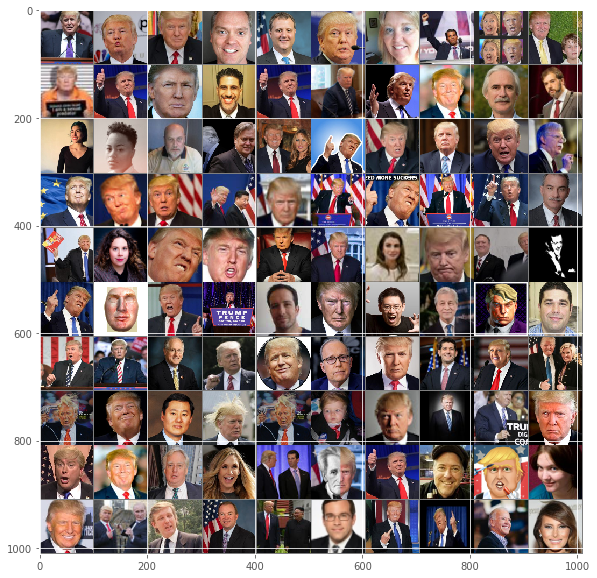

In [7]:
assert(imgs.shape == (100, 100, 100, 3))
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(imgs, saveto='dataset.png'))

In [8]:
sess = tf.Session()
mean_img_op = tf.reduce_mean(imgs, axis=0)

In [9]:
mean_img = sess.run(mean_img_op)

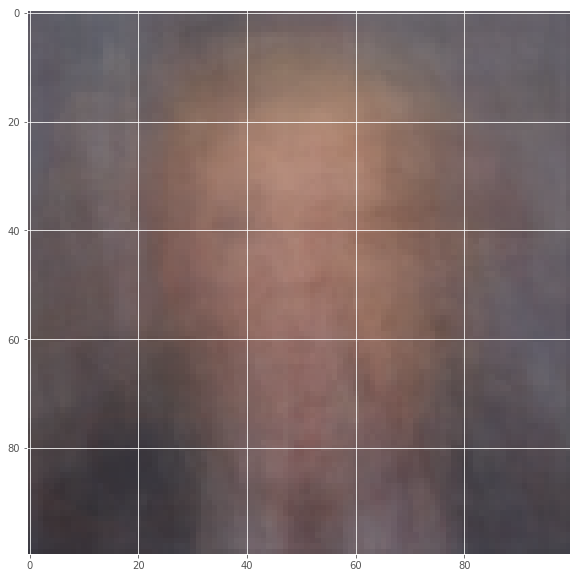

In [10]:
assert(mean_img.shape == (100, 100, 3))
plt.figure(figsize=(10, 10))
plt.imshow(mean_img)
plt.imsave(arr=mean_img, fname='mean.png')

In [11]:
# keep 4d to make the subtraction entailed doable
mean_img_4d = tf.reduce_mean(imgs, axis=0, keepdims=True)

In [12]:
subtraction = imgs - mean_img_4d
std_img_op = tf.sqrt(tf.reduce_mean(subtraction * subtraction, axis=0))
std_img = sess.run(std_img_op)

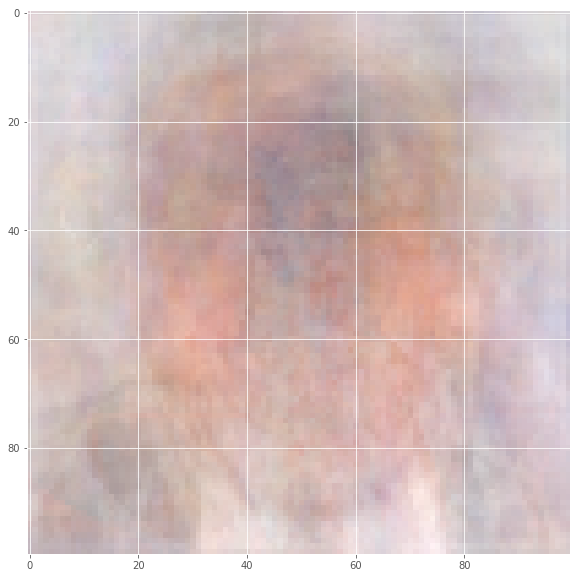

In [13]:
assert(std_img.shape == (100, 100) or std_img.shape == (100, 100, 3))
plt.figure(figsize=(10, 10))
std_img_show = std_img / np.max(std_img)
plt.imshow(std_img_show)
plt.imsave(arr=std_img_show, fname='std.png')

In [14]:
norm_imgs_op = (imgs - mean_img_op) / std_img_op

In [15]:
norm_imgs = sess.run(norm_imgs_op)
print(np.min(norm_imgs), np.max(norm_imgs))
print(imgs.dtype)

-3.3527586 3.6732519
float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


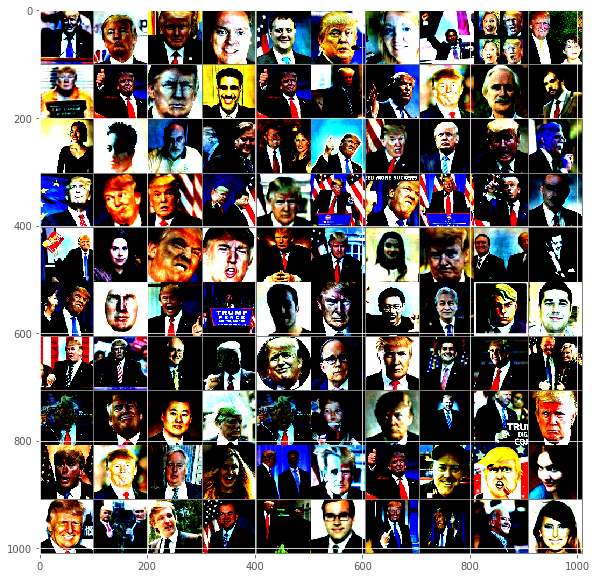

In [16]:
# Then plot the resulting normalized dataset montage:
# Make sure we have a 100 x 100 x 100 x 3 dimension array
assert(norm_imgs.shape == (100, 100, 100, 3))
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(norm_imgs, 'normalized.png'))

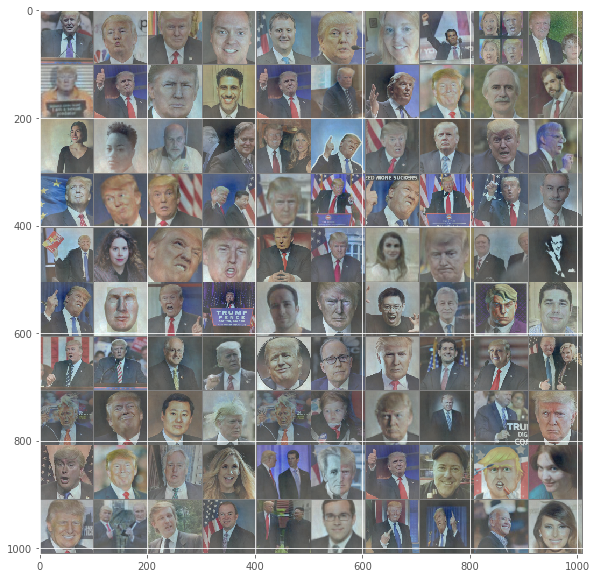

In [17]:
norm_imgs_show = (norm_imgs - np.min(norm_imgs)) / (np.max(norm_imgs) - np.min(norm_imgs))
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(norm_imgs_show, 'normalized.png'))

In [18]:
ksize = 50
kernel = np.concatenate([utils.gabor(ksize)[:, :, np.newaxis] for i in range(3)], axis=2)

kernel_4d = np.expand_dims(kernel, -1)
assert(kernel_4d.shape == (ksize, ksize, 3, 1))

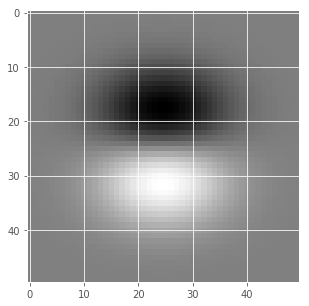

In [19]:
plt.figure(figsize=(5, 5))
plt.imshow(kernel_4d[:, :, 0, 0], cmap='gray')
plt.imsave(arr=kernel_4d[:, :, 0, 0], fname='kernel.png', cmap='gray')

In [20]:
convolved = utils.convolve(imgs, kernel_4d)

In [21]:
print(convolved.shape)
type(convolved)

(100, 100, 100, 1)


numpy.ndarray

(100, 100, 100, 1)


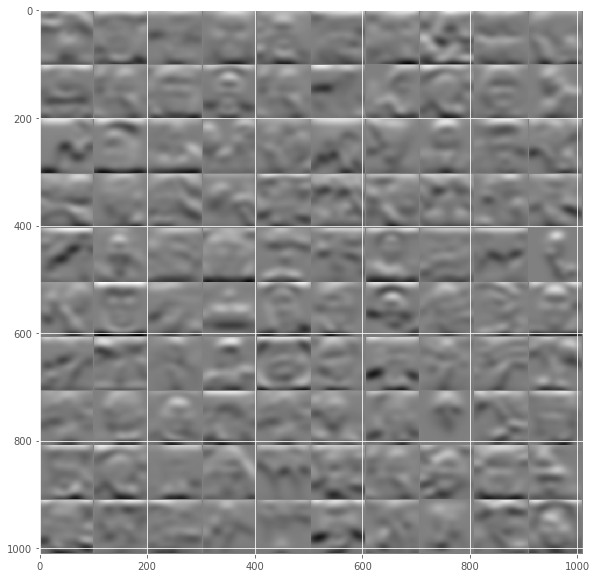

In [22]:
convolved_show = (convolved - np.min(convolved)) / (np.max(convolved) - np.min(convolved))
print(convolved_show.shape)
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(convolved_show[..., 0], 'convolved.png'), cmap='gray')

In [23]:
flattened = tf.reshape(convolved, (100, 10000));
assert(flattened.get_shape().as_list() == [100, 10000])

In [24]:
values = tf.reduce_sum(flattened, axis=1)
idxs_op = tf.nn.top_k(values, k=100)[1]
idxs = sess.run(idxs_op)
sorted_imgs = np.array([imgs[idx_i] for idx_i in idxs])

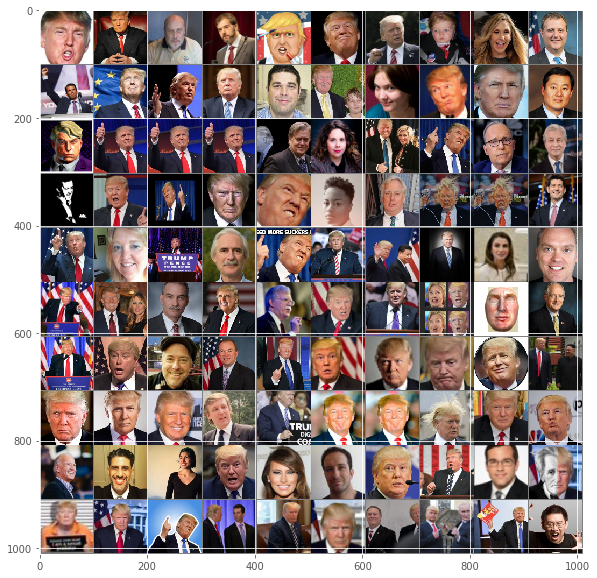

In [25]:
assert(sorted_imgs.shape == (100, 100, 100, 3))
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(sorted_imgs, 'sorted.png'))